<h1 align="center">Machine Learning and Vision Lab</h1>
<h4 align="center">Dr. Mohammadzadeh</h4>
<h4 align="center">Sharif University of Technology, Fall 2023</h4>
<h4 align="center">Amir Hossein Yari - 99102507</h4>
<h4 align="center">Lab 9 - Neural Networks</h4>

#### Implement AND Gate with Perceptron

![0*9QQhdtqhL6H2yMJ4.gif](https://miro.medium.com/v2/resize:fit:598/format:webp/0*9QQhdtqhL6H2yMJ4.gif)

$$\Large{y = x_1+x_2–1}$$

![1*TENIyXDCeJNAB8p8_xTfaQ.png](https://miro.medium.com/v2/resize:fit:640/format:webp/1*TENIyXDCeJNAB8p8_xTfaQ.png)

In [7]:
# Import required package
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import os
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import pandas as pd
import torch.nn.functional as F

In [8]:
zip_path = '/content/FER-2013.zip'
extract_path = '/content/FER-2013'

# Unzip the file
import zipfile
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Define data transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Define a custom dataset to exclude the "disgust" label
class CustomImageFolder(Dataset):
    def __init__(self, root, transform=None, exclude_label=None):
        self.root = root
        self.transform = transform
        self.exclude_label = exclude_label
        self.dataset = datasets.ImageFolder(root=self.root, transform=self.transform)

    def __getitem__(self, index):
        image, label = self.dataset[index]

        # If the label is the one to be excluded, skip and get the next item
        while label == self.exclude_label:
            index = (index + 1) % len(self.dataset)
            image, label = self.dataset[index]

        return image, label

    def __len__(self):
        return len(self.dataset)

# Exclude "disgust" label from the datasets
exclude_label = 1

train_dataset = CustomImageFolder(root=extract_path+'/FER-2013/train', transform=transform, exclude_label=exclude_label)
val_dataset = CustomImageFolder(root=extract_path+'/FER-2013/val', transform=transform, exclude_label=exclude_label)
test_dataset = CustomImageFolder(root=extract_path+'/FER-2013/test', transform=transform, exclude_label=exclude_label)

# Define batch size
batch_size = 64

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

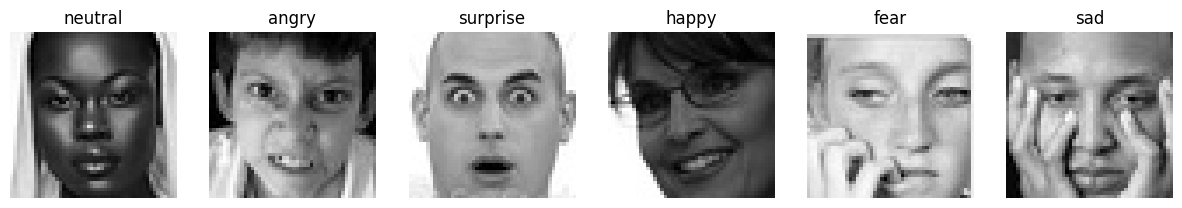

In [9]:
# Function to plot an image from each class
def plot_images_from_each_class(loader, class_names):
    # Get one sample from each class
    class_samples = {}
    for data in loader:
        images, labels = data
        for image, label in zip(images, labels):
            class_name = class_names[label.item()]
            if class_name not in class_samples:
                class_samples[class_name] = image

    # Plot the images
    plt.figure(figsize=(15, 5))
    for i, (class_name, image) in enumerate(class_samples.items()):
        plt.subplot(1, len(class_samples), i + 1)
        plt.title(class_name)
        plt.imshow(np.transpose(image.numpy(), (1, 2, 0)), cmap='gray')
        plt.axis('off')

    plt.show()

# Get class names from the dataset
class_names = train_dataset.dataset.classes

# Plot an image from each class in the training dataset
plot_images_from_each_class(train_loader, class_names)

In [10]:
# Check if a GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Simple Neural Network Without Hidden Layer

In [11]:
# Define the neural network
class SimpleClassifier(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleClassifier, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [12]:
# Set hyperparameters
input_size = 48 * 48
output_size = len(class_names)  # Number of classes
learning_rate = 0.001
batch_size = 64
epochs = 10

# Initialize the model, loss function, and optimizer
model = SimpleClassifier(input_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # Validation
    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_accuracy = correct_val / total_val

    # Save metrics for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Print the metrics for each epoch
    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch 1/10, Train Loss: 1.7185, Train Accuracy: 0.2958, Val Loss: 1.6903, Val Accuracy: 0.2928
Epoch 2/10, Train Loss: 1.6422, Train Accuracy: 0.3419, Val Loss: 1.6498, Val Accuracy: 0.3344
Epoch 3/10, Train Loss: 1.6255, Train Accuracy: 0.3524, Val Loss: 1.6231, Val Accuracy: 0.3449
Epoch 4/10, Train Loss: 1.6035, Train Accuracy: 0.3630, Val Loss: 1.6443, Val Accuracy: 0.3405
Epoch 5/10, Train Loss: 1.6051, Train Accuracy: 0.3660, Val Loss: 1.6509, Val Accuracy: 0.3388
Epoch 6/10, Train Loss: 1.5912, Train Accuracy: 0.3695, Val Loss: 1.6245, Val Accuracy: 0.3377
Epoch 7/10, Train Loss: 1.5937, Train Accuracy: 0.3709, Val Loss: 1.6337, Val Accuracy: 0.3360
Epoch 8/10, Train Loss: 1.5837, Train Accuracy: 0.3765, Val Loss: 1.6266, Val Accuracy: 0.3385
Epoch 9/10, Train Loss: 1.5738, Train Accuracy: 0.3765, Val Loss: 1.6149, Val Accuracy: 0.3658
Epoch 10/10, Train Loss: 1.5742, Train Accuracy: 0.3791, Val Loss: 1.6301, Val Accuracy: 0.3438


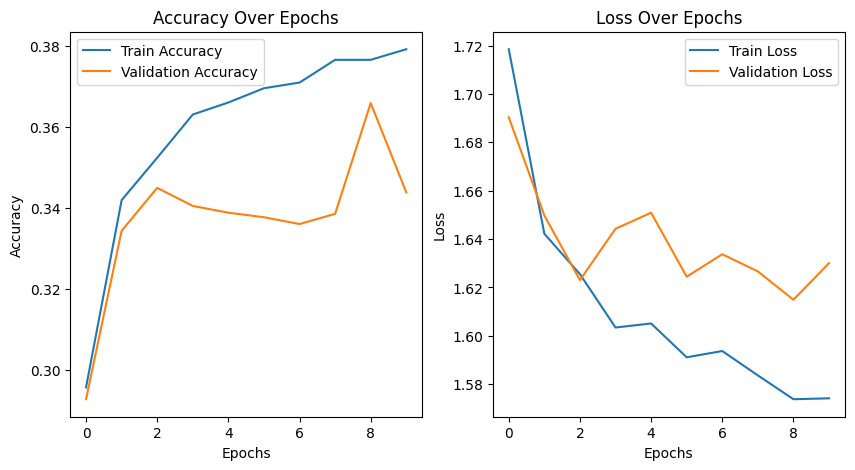

In [13]:
# Plotting accuracy and loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Test Accuracy: 0.3346


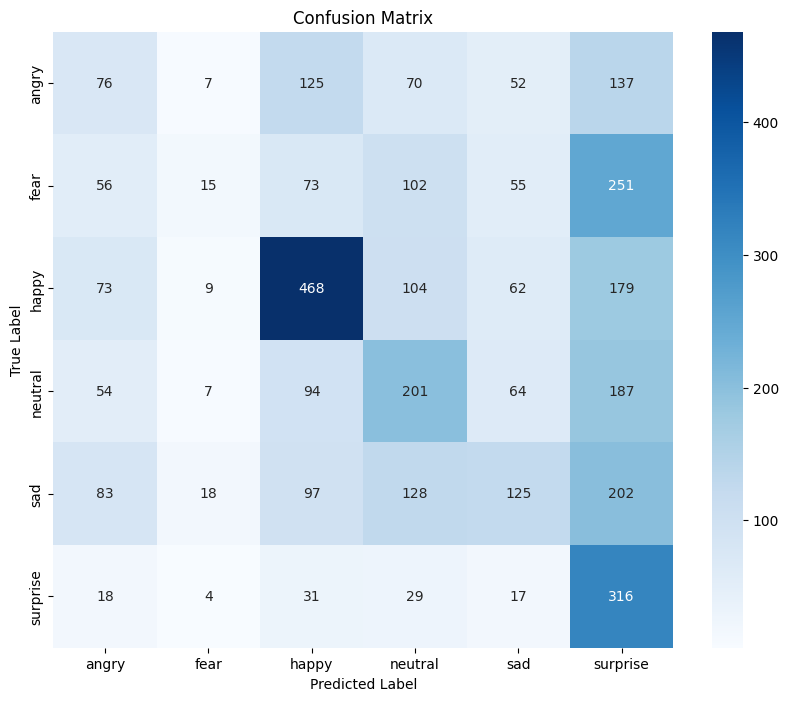

In [14]:
# Evaluate the model on the test set
model.eval()
all_predictions = []
all_labels = []

# Update class_names to exclude "disgust"
modified_class_names = [class_name for class_name in class_names if class_name != 'disgust']

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
test_accuracy = accuracy_score(all_labels, all_predictions)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=modified_class_names, yticklabels=modified_class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Add Hidden Layer

In [15]:
class ModifiedMLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(ModifiedMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

In [16]:
# Set hyperparameters
input_size = 48 * 48
output_size = len(class_names)  # Number of classes
hidden_size1 = 288
hidden_size2 = 72
learning_rate = 0.001
batch_size = 64
epochs = 10

# Initialize the model, loss function, and optimizer
model = ModifiedMLP(input_size, hidden_size1, hidden_size2, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # Validation
    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_accuracy = correct_val / total_val

    # Save metrics for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Print the metrics for each epoch
    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch 1/10, Train Loss: 1.7083, Train Accuracy: 0.2899, Val Loss: 1.6463, Val Accuracy: 0.3243
Epoch 2/10, Train Loss: 1.6059, Train Accuracy: 0.3521, Val Loss: 1.6022, Val Accuracy: 0.3424
Epoch 3/10, Train Loss: 1.5822, Train Accuracy: 0.3651, Val Loss: 1.5964, Val Accuracy: 0.3541
Epoch 4/10, Train Loss: 1.5574, Train Accuracy: 0.3752, Val Loss: 1.5644, Val Accuracy: 0.3667
Epoch 5/10, Train Loss: 1.5408, Train Accuracy: 0.3818, Val Loss: 1.5729, Val Accuracy: 0.3608
Epoch 6/10, Train Loss: 1.5293, Train Accuracy: 0.3871, Val Loss: 1.5537, Val Accuracy: 0.3725
Epoch 7/10, Train Loss: 1.5167, Train Accuracy: 0.3921, Val Loss: 1.5795, Val Accuracy: 0.3594
Epoch 8/10, Train Loss: 1.5041, Train Accuracy: 0.3987, Val Loss: 1.5317, Val Accuracy: 0.3789
Epoch 9/10, Train Loss: 1.4911, Train Accuracy: 0.4061, Val Loss: 1.5196, Val Accuracy: 0.3859
Epoch 10/10, Train Loss: 1.4758, Train Accuracy: 0.4152, Val Loss: 1.5176, Val Accuracy: 0.3934


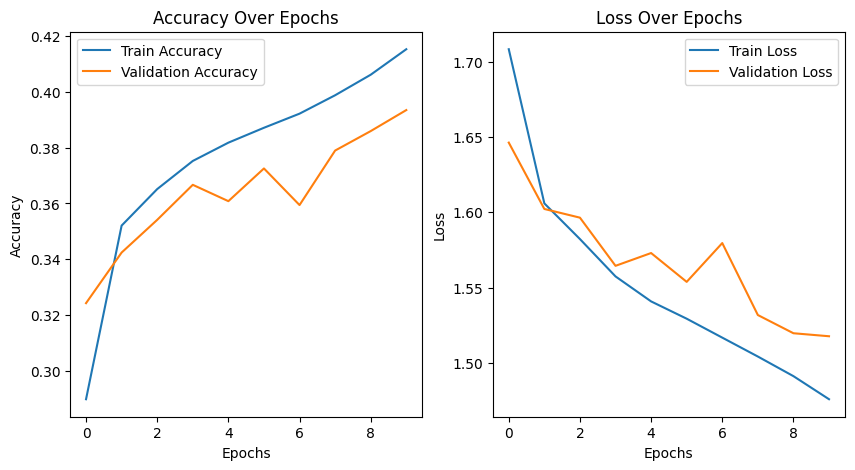

In [17]:
# Plotting accuracy and loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Test Accuracy: 0.3912


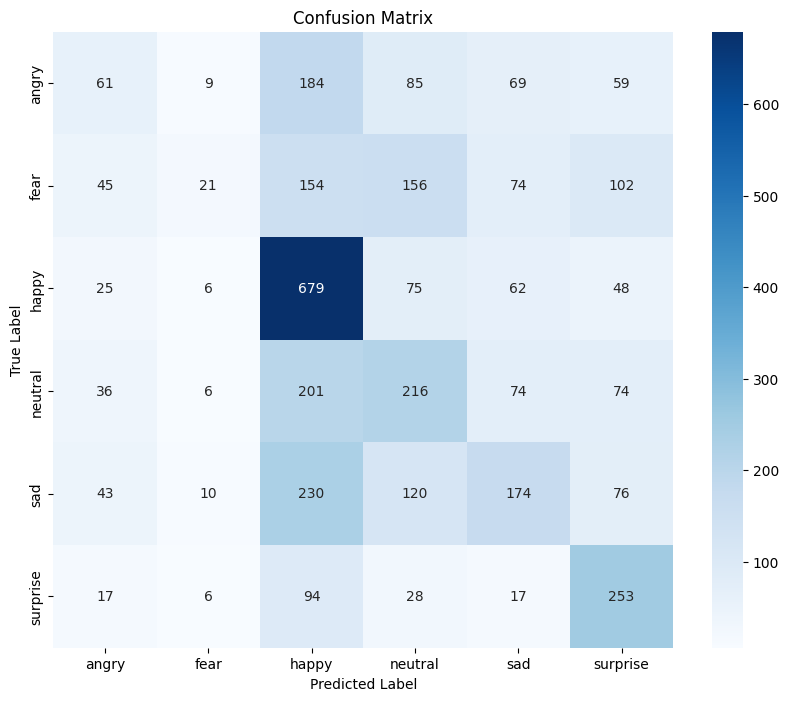

In [18]:
# Evaluate the model on the test set
model.eval()
all_predictions = []
all_labels = []

# Update class_names to exclude "disgust"
modified_class_names = [class_name for class_name in class_names if class_name != 'disgust']

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
test_accuracy = accuracy_score(all_labels, all_predictions)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=modified_class_names, yticklabels=modified_class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Different Learning Rate

Learning Rate: 0.1, Epoch 1/5, Train Loss: 8.7093, Train Accuracy: 0.2469, Val Loss: 1.7742, Val Accuracy: 0.2449
Learning Rate: 0.1, Epoch 2/5, Train Loss: 1.7643, Train Accuracy: 0.2510, Val Loss: 1.7810, Val Accuracy: 0.2449
Learning Rate: 0.1, Epoch 3/5, Train Loss: 1.7659, Train Accuracy: 0.2504, Val Loss: 1.7811, Val Accuracy: 0.2449
Learning Rate: 0.1, Epoch 4/5, Train Loss: 1.7658, Train Accuracy: 0.2493, Val Loss: 1.7767, Val Accuracy: 0.2449
Learning Rate: 0.1, Epoch 5/5, Train Loss: 1.7650, Train Accuracy: 0.2513, Val Loss: 1.7765, Val Accuracy: 0.2449
Test Accuracy (LR=0.1): 0.2494
Learning Rate: 0.01, Epoch 1/5, Train Loss: 1.8053, Train Accuracy: 0.2656, Val Loss: 1.6783, Val Accuracy: 0.3087
Learning Rate: 0.01, Epoch 2/5, Train Loss: 1.6471, Train Accuracy: 0.3262, Val Loss: 1.6566, Val Accuracy: 0.3221
Learning Rate: 0.01, Epoch 3/5, Train Loss: 1.6177, Train Accuracy: 0.3423, Val Loss: 1.6255, Val Accuracy: 0.3318
Learning Rate: 0.01, Epoch 4/5, Train Loss: 1.6059, Tr

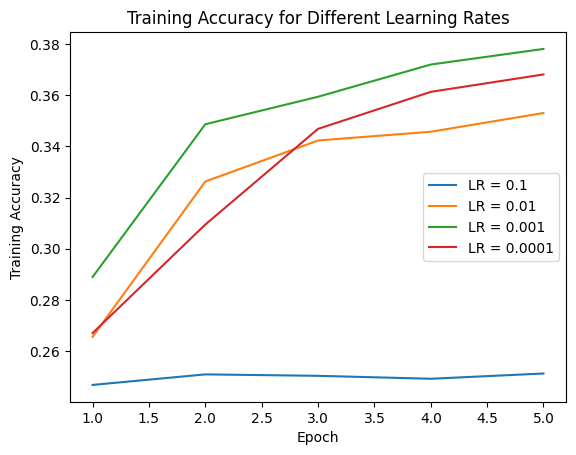

In [19]:
# Set hyperparameters
input_size = 48 * 48
output_size = len(class_names)  # Number of classes
hidden_size1 = 288
hidden_size2 = 72
epochs = 5

# Experiment with different learning rates
learning_rates = [0.1, 0.01, 0.001, 0.0001]

for learning_rate in learning_rates:
    # Initialize the model, loss function, and optimizer
    model = ModifiedMLP(input_size, hidden_size1, hidden_size2, output_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        # Validation
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_accuracy = correct_val / total_val

        # Save metrics for plotting or analysis
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Print the metrics for each epoch
        print(f'Learning Rate: {learning_rate}, Epoch {epoch + 1}/{epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Evaluate on the test set
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    test_accuracy = accuracy_score(all_labels, all_predictions)
    print(f'Test Accuracy (LR={learning_rate}): {test_accuracy:.4f}')

    # Plot the training accuracy for each learning rate
    plt.plot(range(1, epochs + 1), train_accuracies, label=f'LR = {learning_rate}')

# Add labels and legend to the plot
plt.title('Training Accuracy for Different Learning Rates')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.legend()
plt.show()

#### Effect of Learning Rate

##### 1. Convergence Speed:

- A higher learning rate allows the model to converge faster as it takes larger steps towards the optimal solution. However, setting it too high can cause the model to overshoot the minimum and lead to divergence.
  
- A lower learning rate slows down the convergence process but provides more stability. It helps in reaching the minimum more accurately, but training might take longer.

##### 2. Overshooting and Divergence:

- If the learning rate is too high, the model may overshoot the optimal weights and biases, causing the loss to increase or fluctuate. This can lead to divergence, and the model fails to converge to a solution.

##### 3. Local Minima Avoidance:

- A moderate learning rate can help the model navigate through local minima and reach a more optimal global minimum. Very small learning rates might get stuck in local minima, while very large ones might skip over them.

##### 4. Learning Rate Scheduling:

- Learning rate scheduling involves adjusting the learning rate during training. It can be useful to start with a higher learning rate for faster initial convergence and then gradually reduce it to allow for finer adjustments.

##### 5. Stability and Robustness:

- A well-chosen learning rate contributes to the stability and robustness of the training process. It helps maintain a smooth descent towards the optimal solution, avoiding oscillations or erratic behavior.

##### 6. Grid Search or Hyperparameter Tuning:

- Finding the optimal learning rate often involves experimentation. Researchers and practitioners often perform grid searches or use more advanced techniques like learning rate annealing to find the best learning rate for a particular task and model architecture.

#### Different Optimizer

Optimizer = SGD, Epoch 1/5, Train Loss: 1.7898, Train Accuracy: 0.2463, Val Loss: 1.7664, Val Accuracy: 0.2611
Optimizer = SGD, Epoch 2/5, Train Loss: 1.7420, Train Accuracy: 0.2646, Val Loss: 1.7487, Val Accuracy: 0.2686
Optimizer = SGD, Epoch 3/5, Train Loss: 1.7139, Train Accuracy: 0.2819, Val Loss: 1.7132, Val Accuracy: 0.2990
Optimizer = SGD, Epoch 4/5, Train Loss: 1.6803, Train Accuracy: 0.3116, Val Loss: 1.6687, Val Accuracy: 0.3310
Optimizer = SGD, Epoch 5/5, Train Loss: 1.6463, Train Accuracy: 0.3358, Val Loss: 1.6423, Val Accuracy: 0.3444
Test Accuracy (Optimizer=SGD): 0.3422
Optimizer = Adam, Epoch 1/5, Train Loss: 1.7033, Train Accuracy: 0.2907, Val Loss: 1.6419, Val Accuracy: 0.3296
Optimizer = Adam, Epoch 2/5, Train Loss: 1.6198, Train Accuracy: 0.3453, Val Loss: 1.6070, Val Accuracy: 0.3410
Optimizer = Adam, Epoch 3/5, Train Loss: 1.5909, Train Accuracy: 0.3580, Val Loss: 1.5832, Val Accuracy: 0.3505
Optimizer = Adam, Epoch 4/5, Train Loss: 1.5637, Train Accuracy: 0.3717

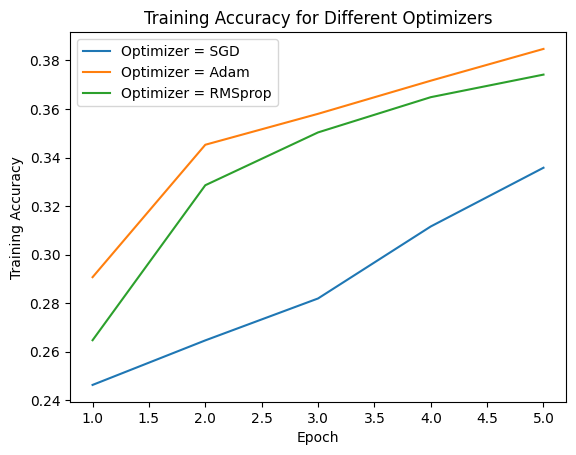

In [20]:
# Set hyperparameters
input_size = 48 * 48
output_size = len(class_names)  # Number of classes
hidden_size1 = 288
hidden_size2 = 72
epochs = 5

# Experiment with different optimizers
optimizers = ['SGD', 'Adam', 'RMSprop']

for optimizer_name in optimizers:
    # Initialize the model, loss function, and optimizer
    model = ModifiedMLP(input_size, hidden_size1, hidden_size2, output_size).to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=0.001)

    # Training loop
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        # Validation
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_accuracy = correct_val / total_val

        # Save metrics for plotting or analysis
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Print the metrics for each epoch
        print(f'Optimizer = {optimizer_name}, Epoch {epoch + 1}/{epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Evaluate on the test set
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    test_accuracy = accuracy_score(all_labels, all_predictions)
    print(f'Test Accuracy (Optimizer={optimizer_name}): {test_accuracy:.4f}')

    # Plot the training accuracy for each optimizer
    plt.plot(range(1, epochs + 1), train_accuracies, label=f'Optimizer = {optimizer_name}')

# Add labels and legend to the plot
plt.title('Training Accuracy for Different Optimizers')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.legend()
plt.show()

## Effect of Optimizers

### 1. Stochastic Gradient Descent (SGD)

- **Description:**
  - Basic optimization algorithm that updates the model parameters in the opposite direction of the gradient of the loss function.
  - Parameters are updated by taking a step proportional to the negative of the gradient.
  - Simple and easy to implement but may have slow convergence, especially in complex loss surfaces or high-dimensional data.

### 2. Adam (Adaptive Moment Estimation)

- **Description:**
  - Adaptive learning rate optimization algorithm that combines ideas from momentum and RMSprop.
  - Maintains two moving averages for each parameter: the first moment (mean) and the second moment (uncentered variance).
  - Adapts learning rates based on the magnitude of the first and second moments, providing faster convergence and better handling of sparse gradients.
  - Widely used in practice due to its good performance across various tasks.

### 3. RMSprop (Root Mean Square Propagation)

- **Description:**
  - Adaptive learning rate optimization algorithm addressing issues with SGD, especially in non-uniformly scaled features or sparse data.
  - Maintains an exponentially decaying average of squared gradients for each parameter.
  - Adjusts learning rates individually for each parameter based on the magnitude of squared gradients, preventing learning rates from decreasing too fast for frequently occurring features.
  - Results in faster convergence and improved performance in certain scenarios.

#### Different Batch Size

Batch Size = 32, Epoch 1/5, Train Loss: 1.6948, Train Accuracy: 0.2945, Val Loss: 1.6741, Val Accuracy: 0.2970
Batch Size = 32, Epoch 2/5, Train Loss: 1.6192, Train Accuracy: 0.3425, Val Loss: 1.6251, Val Accuracy: 0.3438
Batch Size = 32, Epoch 3/5, Train Loss: 1.5862, Train Accuracy: 0.3616, Val Loss: 1.5860, Val Accuracy: 0.3642
Batch Size = 32, Epoch 4/5, Train Loss: 1.5598, Train Accuracy: 0.3740, Val Loss: 1.5880, Val Accuracy: 0.3522
Batch Size = 32, Epoch 5/5, Train Loss: 1.5501, Train Accuracy: 0.3793, Val Loss: 1.5773, Val Accuracy: 0.3661
Test Accuracy (Batch Size=32): 0.3748
Batch Size = 64, Epoch 1/5, Train Loss: 1.7025, Train Accuracy: 0.2964, Val Loss: 1.6591, Val Accuracy: 0.3349
Batch Size = 64, Epoch 2/5, Train Loss: 1.6155, Train Accuracy: 0.3462, Val Loss: 1.6921, Val Accuracy: 0.2948
Batch Size = 64, Epoch 3/5, Train Loss: 1.5862, Train Accuracy: 0.3607, Val Loss: 1.5894, Val Accuracy: 0.3653
Batch Size = 64, Epoch 4/5, Train Loss: 1.5583, Train Accuracy: 0.3765, Va

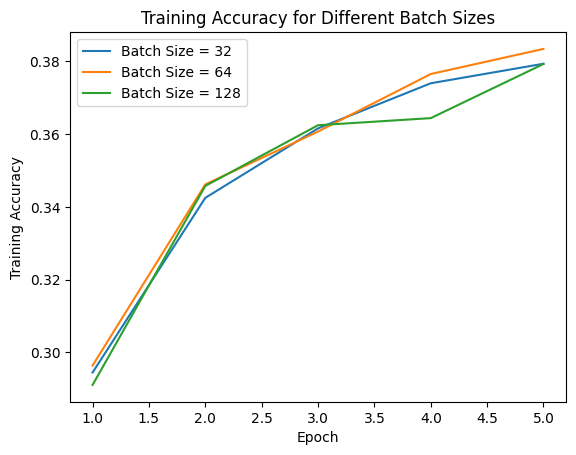

In [21]:
# Set hyperparameters
input_size = 48 * 48
output_size = len(class_names)  # Number of classes
hidden_size1 = 288
hidden_size2 = 72
epochs = 5

# Experiment with different batch sizes
batch_sizes = [32, 64, 128]

for batch_size in batch_sizes:
    # Initialize the model, loss function, and optimizer
    model = ModifiedMLP(input_size, hidden_size1, hidden_size2, output_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Update batch size in the data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Training loop
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        # Validation
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_accuracy = correct_val / total_val

        # Save metrics for plotting or analysis
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Print the metrics for each epoch
        print(f'Batch Size = {batch_size}, Epoch {epoch + 1}/{epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Evaluate on the test set
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    test_accuracy = accuracy_score(all_labels, all_predictions)
    print(f'Test Accuracy (Batch Size={batch_size}): {test_accuracy:.4f}')

    # Plot the training accuracy for each batch size
    plt.plot(range(1, epochs + 1), train_accuracies, label=f'Batch Size = {batch_size}')

# Add labels and legend to the plot
plt.title('Training Accuracy for Different Batch Sizes')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.legend()
plt.show()

#### Effect of Batch Size

1. **Computational Efficiency:**
   - Smaller batch sizes consume less memory, making them suitable for hardware with limited resources.
   - Larger batch sizes can take advantage of parallel processing and may lead to faster training times.

2. **Generalization:**
   - Smaller batch sizes contribute to better generalization as the model updates more frequently.
   - Larger batch sizes may lead to smoother convergence but may increase the risk of overfitting.

3. **Stochasticity and Noise:**
   - Smaller batch sizes introduce more stochasticity, helping the model escape local minima.
   - Larger batch sizes result in a more deterministic training process.

4. **Convergence Speed:**
   - Smaller batch sizes accelerate convergence due to more frequent weight updates.
   - Larger batch sizes may require more iterations to converge, but each iteration is more computationally efficient.

5. **Memory Requirements:**
   - Smaller batch sizes consume less memory, beneficial for devices with limited resources.
   - Larger batch sizes may require more memory.

#### Different Number of Epochs

Number of Epochs = 2, Epoch 1/2, Train Loss: 1.7141, Train Accuracy: 0.2870, Val Loss: 1.7407, Val Accuracy: 0.2747
Number of Epochs = 2, Epoch 2/2, Train Loss: 1.6264, Train Accuracy: 0.3394, Val Loss: 1.6413, Val Accuracy: 0.3313
Test Accuracy (Epochs=2): 0.3324
Number of Epochs = 5, Epoch 1/5, Train Loss: 1.7056, Train Accuracy: 0.2939, Val Loss: 1.6506, Val Accuracy: 0.3263
Number of Epochs = 5, Epoch 2/5, Train Loss: 1.6329, Train Accuracy: 0.3404, Val Loss: 1.6158, Val Accuracy: 0.3444
Number of Epochs = 5, Epoch 3/5, Train Loss: 1.5915, Train Accuracy: 0.3631, Val Loss: 1.5792, Val Accuracy: 0.3475
Number of Epochs = 5, Epoch 4/5, Train Loss: 1.5730, Train Accuracy: 0.3695, Val Loss: 1.5714, Val Accuracy: 0.3636
Number of Epochs = 5, Epoch 5/5, Train Loss: 1.5533, Train Accuracy: 0.3809, Val Loss: 1.5637, Val Accuracy: 0.3608
Test Accuracy (Epochs=5): 0.3792
Number of Epochs = 10, Epoch 1/10, Train Loss: 1.7327, Train Accuracy: 0.2760, Val Loss: 1.6777, Val Accuracy: 0.3146
Numb

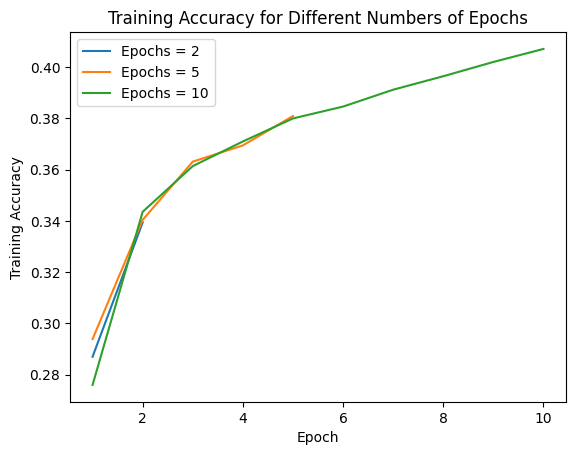

In [22]:
# Set hyperparameters
input_size = 48 * 48
output_size = len(class_names)  # Number of classes
hidden_size1 = 288
hidden_size2 = 72

# Experiment with different numbers of epochs
epochs_list = [2, 5, 10]

for epochs in epochs_list:
    # Initialize the model, loss function, and optimizer
    model = ModifiedMLP(input_size, hidden_size1, hidden_size2, output_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        # Validation
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_accuracy = correct_val / total_val

        # Save metrics for plotting or analysis
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Print the metrics for each epoch
        print(f'Number of Epochs = {epochs}, Epoch {epoch + 1}/{epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Evaluate on the test set
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    test_accuracy = accuracy_score(all_labels, all_predictions)
    print(f'Test Accuracy (Epochs={epochs}): {test_accuracy:.4f}')

    # Plot the training accuracy for each number of epochs
    plt.plot(range(1, epochs + 1), train_accuracies, label=f'Epochs = {epochs}')

# Add labels and legend to the plot
plt.title('Training Accuracy for Different Numbers of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.legend()
plt.show()

#### Effect of Number of Epochs

##### Underfitting and Overfitting
- **Underfitting:** If the number of epochs is too low, the model may not learn well from the training data, resulting in underfitting. The model fails to capture underlying patterns.
- **Overfitting:** Conversely, if the number of epochs is too high, the model may memorize the training data and perform poorly on new, unseen data, leading to overfitting.

##### Convergence
- The training process aims to minimize the loss function, and the number of epochs determines how many iterations the model has to converge to a minimum. Ongoing decrease in loss indicates continued learning.

##### Validation Performance
- Monitoring validation performance is crucial to prevent overfitting. If validation performance degrades while training performance improves, it may indicate overfitting, and training adjustments are needed.

##### Computational Resources
- The number of epochs affects the computational resources required for training. More epochs generally demand more computing time and resources.

##### Early Stopping
- Practitioners often use techniques like early stopping, which involves monitoring validation performance and stopping training when it starts to degrade.

#### CNN Model

In [23]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = self.pool4(torch.relu(self.conv4(x)))
        x = x.view(-1, 128 * 3 * 3)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [24]:
# Assuming class_names is a list of emotion labels
num_classes = len(class_names)

# Function to train and evaluate the model
def train_and_evaluate_model(model, train_loader, val_loader, test_loader, num_epochs=10, learning_rate=0.001, batch_size=64):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validate the model
        model.eval()
        with torch.no_grad():
            val_accuracy = 0.0
            val_loss = 0.0
            total_samples = 0

            for inputs, labels in val_loader:
                inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total_samples += labels.size(0)
                val_accuracy += (predicted == labels).sum().item()
                val_loss += criterion(outputs, labels).item()

            val_accuracy /= total_samples
            val_loss /= total_samples

            train_losses.append(train_loss / len(train_loader))
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'Train Loss: {train_loss / len(train_loader):.4f}, '
                  f'Train Accuracy: {train_accuracy:.4f}, '
                  f'Validation Loss: {val_loss:.4f}, '
                  f'Validation Accuracy: {val_accuracy:.4f}')

    return train_accuracies, train_losses, val_accuracies, val_losses

# Scenario 1: Default hyperparameters
model1 = SimpleCNN(num_classes)
train_accuracies1, train_losses1, val_accuracies1, val_losses1 = train_and_evaluate_model(model1, train_loader, val_loader, test_loader)

# Scenario 2: Different learning rate
model2 = SimpleCNN(num_classes)
train_accuracies2, train_losses2, val_accuracies2, val_losses2 = train_and_evaluate_model(model2, train_loader, val_loader, test_loader, learning_rate=0.01)

# Scenario 3: Different batch size
model3 = SimpleCNN(num_classes)
train_accuracies3, train_losses3, val_accuracies3, val_losses3 = train_and_evaluate_model(model3, train_loader, val_loader, test_loader, batch_size=32)

# Scenario 4: Different number of epoch
model4 = SimpleCNN(num_classes)
train_accuracies4, train_losses4, val_accuracies4, val_losses4 = train_and_evaluate_model(model4, train_loader, val_loader, test_loader, num_epochs=5)

Epoch [1/10], Train Loss: 1.7364, Train Accuracy: 0.2628, Validation Loss: 0.0258, Validation Accuracy: 0.3070
Epoch [2/10], Train Loss: 1.4793, Train Accuracy: 0.4005, Validation Loss: 0.0222, Validation Accuracy: 0.4427
Epoch [3/10], Train Loss: 1.3081, Train Accuracy: 0.4811, Validation Loss: 0.0205, Validation Accuracy: 0.4762
Epoch [4/10], Train Loss: 1.2084, Train Accuracy: 0.5258, Validation Loss: 0.0193, Validation Accuracy: 0.5280
Epoch [5/10], Train Loss: 1.1326, Train Accuracy: 0.5595, Validation Loss: 0.0192, Validation Accuracy: 0.5163
Epoch [6/10], Train Loss: 1.0610, Train Accuracy: 0.5922, Validation Loss: 0.0192, Validation Accuracy: 0.5146
Epoch [7/10], Train Loss: 0.9867, Train Accuracy: 0.6230, Validation Loss: 0.0189, Validation Accuracy: 0.5378
Epoch [8/10], Train Loss: 0.9151, Train Accuracy: 0.6524, Validation Loss: 0.0194, Validation Accuracy: 0.5327
Epoch [9/10], Train Loss: 0.8371, Train Accuracy: 0.6830, Validation Loss: 0.0193, Validation Accuracy: 0.5545
E

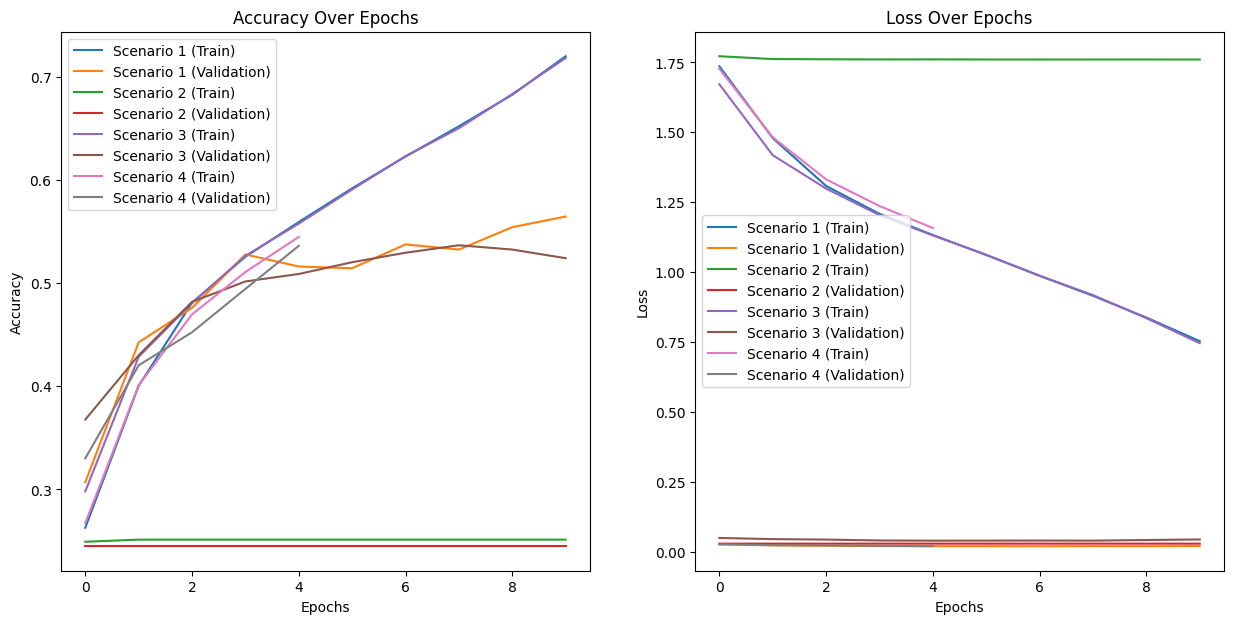

In [25]:
# Plotting accuracy and loss for all models
plt.figure(figsize=(15, 7))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracies1, label='Scenario 1 (Train)')
plt.plot(val_accuracies1, label='Scenario 1 (Validation)')
plt.plot(train_accuracies2, label='Scenario 2 (Train)')
plt.plot(val_accuracies2, label='Scenario 2 (Validation)')
plt.plot(train_accuracies3, label='Scenario 3 (Train)')
plt.plot(val_accuracies3, label='Scenario 3 (Validation)')
plt.plot(train_accuracies4, label='Scenario 4 (Train)')
plt.plot(val_accuracies4, label='Scenario 4 (Validation)')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(train_losses1, label='Scenario 1 (Train)')
plt.plot(val_losses1, label='Scenario 1 (Validation)')
plt.plot(train_losses2, label='Scenario 2 (Train)')
plt.plot(val_losses2, label='Scenario 2 (Validation)')
plt.plot(train_losses3, label='Scenario 3 (Train)')
plt.plot(val_losses3, label='Scenario 3 (Validation)')
plt.plot(train_losses4, label='Scenario 4 (Train)')
plt.plot(val_losses4, label='Scenario 4 (Validation)')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Test Accuracy: 0.3784


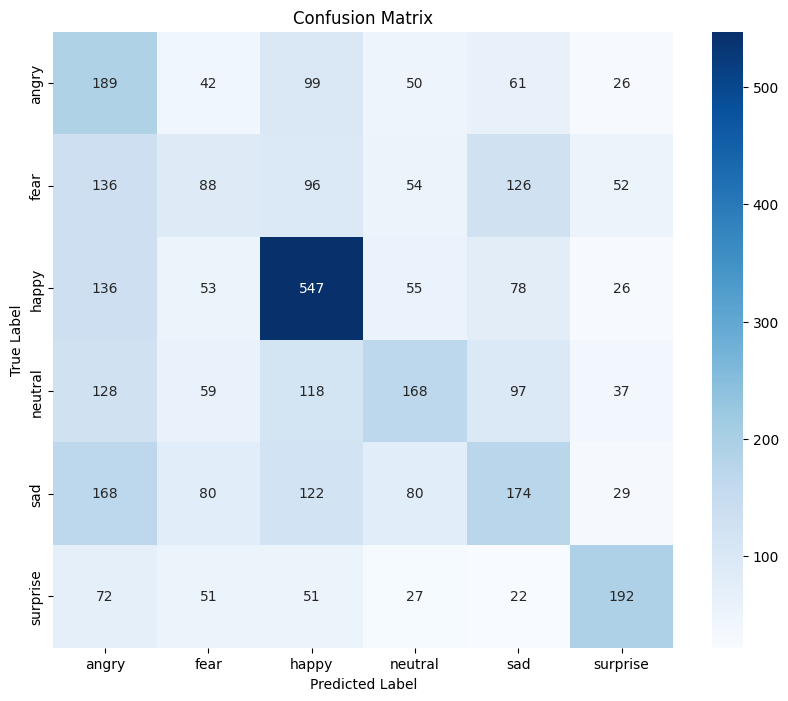

In [26]:
# Evaluate the model on the test set
model1.eval()
all_predictions = []
all_labels = []

# Update class_names to exclude "disgust"
modified_class_names = [class_name for class_name in class_names if class_name != 'disgust']

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
test_accuracy = accuracy_score(all_labels, all_predictions)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=modified_class_names, yticklabels=modified_class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Add Dropout

In [27]:
class ModifiedCNN(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(ModifiedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout2d(dropout_rate)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout2d(dropout_rate)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout2d(dropout_rate)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout4 = nn.Dropout2d(dropout_rate)

        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.dropout_fc1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(512, 256)
        self.dropout_fc2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.dropout1(x)

        x = self.pool2(F.relu(self.conv2(x)))
        x = self.dropout2(x)

        x = self.pool3(F.relu(self.conv3(x)))
        x = self.dropout3(x)

        x = self.pool4(F.relu(self.conv4(x)))
        x = self.dropout4(x)

        x = x.view(-1, 128 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout_fc2(x)

        x = self.fc3(x)
        return x

In [28]:
# Scenario 1: Default hyperparameters with dropout
model1_dropout = ModifiedCNN(num_classes)
train_accuracies1_dropout, train_losses1_dropout, val_accuracies1_dropout, val_losses1_dropout = train_and_evaluate_model(model1_dropout, train_loader, val_loader, test_loader)

# Scenario 2: Different learning rate with dropout
model2_dropout = ModifiedCNN(num_classes)
train_accuracies2_dropout, train_losses2_dropout, val_accuracies2_dropout, val_losses2_dropout = train_and_evaluate_model(model2_dropout, train_loader, val_loader, test_loader, learning_rate=0.01)

# Scenario 3: Different batch size with dropout
model3_dropout = ModifiedCNN(num_classes)
train_accuracies3_dropout, train_losses3_dropout, val_accuracies3_dropout, val_losses3_dropout = train_and_evaluate_model(model3_dropout, train_loader, val_loader, test_loader, batch_size=32)

# Scenario 4: Different number of epochs with dropout
model4_dropout = ModifiedCNN(num_classes)
train_accuracies4_dropout, train_losses4_dropout, val_accuracies4_dropout, val_losses4_dropout = train_and_evaluate_model(model4_dropout, train_loader, val_loader, test_loader, num_epochs=5)


Epoch [1/10], Train Loss: 1.7785, Train Accuracy: 0.2441, Validation Loss: 0.0282, Validation Accuracy: 0.2449
Epoch [2/10], Train Loss: 1.7588, Train Accuracy: 0.2498, Validation Loss: 0.0279, Validation Accuracy: 0.2591
Epoch [3/10], Train Loss: 1.7458, Train Accuracy: 0.2584, Validation Loss: 0.0278, Validation Accuracy: 0.2463
Epoch [4/10], Train Loss: 1.7300, Train Accuracy: 0.2627, Validation Loss: 0.0276, Validation Accuracy: 0.2474
Epoch [5/10], Train Loss: 1.7184, Train Accuracy: 0.2659, Validation Loss: 0.0273, Validation Accuracy: 0.2591
Epoch [6/10], Train Loss: 1.7015, Train Accuracy: 0.2740, Validation Loss: 0.0268, Validation Accuracy: 0.2789
Epoch [7/10], Train Loss: 1.6778, Train Accuracy: 0.2991, Validation Loss: 0.0260, Validation Accuracy: 0.3296
Epoch [8/10], Train Loss: 1.6436, Train Accuracy: 0.3178, Validation Loss: 0.0251, Validation Accuracy: 0.3527
Epoch [9/10], Train Loss: 1.6154, Train Accuracy: 0.3391, Validation Loss: 0.0247, Validation Accuracy: 0.3728
E

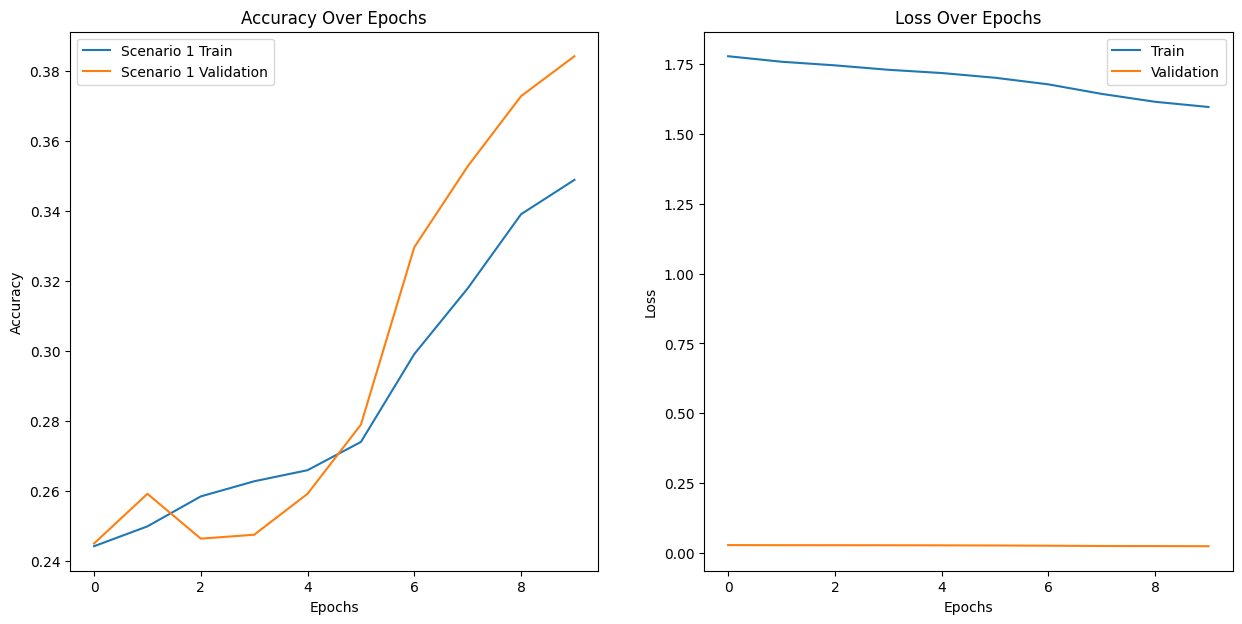

In [31]:
# Plotting accuracy and loss for all models
plt.figure(figsize=(15, 7))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracies1_dropout, label='Scenario 1 Train')
plt.plot(val_accuracies1_dropout, label='Scenario 1 Validation')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(train_losses1_dropout, label='Train')
plt.plot(val_losses1_dropout, label='Validation')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Test Accuracy: 0.3784


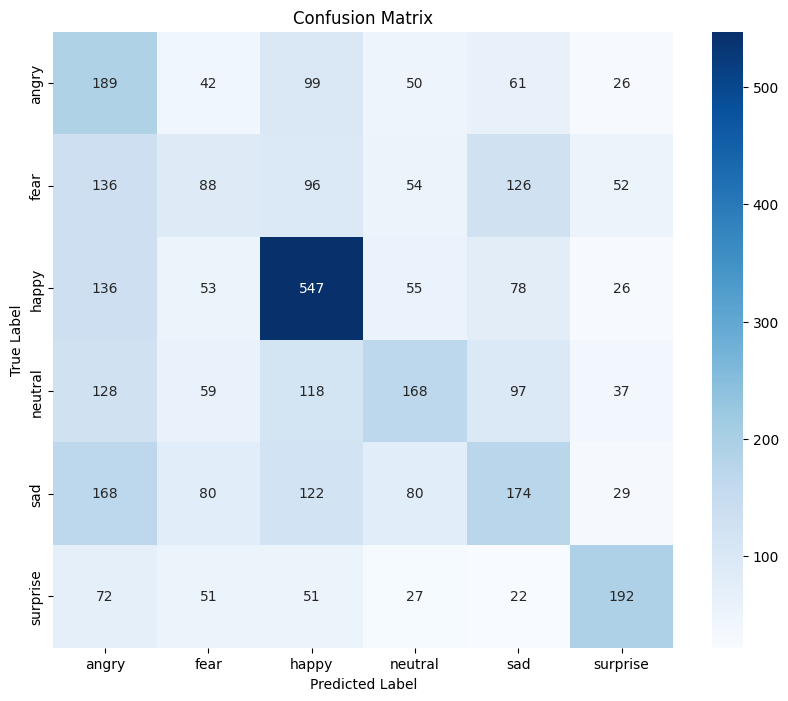

In [32]:
# Evaluate the model on the test set
model1_dropout.eval()
all_predictions = []
all_labels = []

# Update class_names to exclude "disgust"
modified_class_names = [class_name for class_name in class_names if class_name != 'disgust']

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
test_accuracy = accuracy_score(all_labels, all_predictions)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=modified_class_names, yticklabels=modified_class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Regularization Techniques

##### 1. L1 Regularization (Lasso Regression):

- L1 regularization adds the absolute values of the weights as a penalty term to the loss function.
- The regularization term is λ times the sum of the absolute values of the weights (||w||₁).
- This encourages sparsity in the weight matrix, effectively pushing some weights to become exactly zero.
- It is useful for feature selection, as it tends to force the model to use a smaller number of features.

##### 2. L2 Regularization (Ridge Regression):

- L2 regularization adds the squared values of the weights as a penalty term to the loss function.
- The regularization term is λ times the sum of the squared values of the weights (||w||₂²).
- L2 regularization penalizes large weights but does not force them to be exactly zero.
- It is effective in preventing the model from becoming too sensitive to small changes in the input data.

##### 3. Elastic Net Regularization:

- Elastic Net regularization combines both L1 and L2 regularization.
- It adds a combination of the absolute values of the weights and the squared values of the weights to the loss function.
- The regularization term is a linear combination of the L1 and L2 regularization terms.
- Elastic Net combines the sparsity-inducing property of L1 with the smoothing effect of L2, providing a balance between feature selection and weight shrinkage.
